## Проект AdsCalibrationMaster 

Построение модели бинарной классификации, для предсказания вероятности клика (CTR) на рекламное объявление с последующей Калибровкой модели, для обеспечения соответствие между предсказанными вероятностями и фактической частотой кликов.

Проект выложен в гитхаб: https://github.com/LadyTestCode/SVM-12sprint-project

# Структура проекта

Все версии пакетов зафиксированы в файле requirements.txt, файл выложен в  репозиторий вместе с файлом тетрадки.
Импортируем необходимые библиотеки и устанавливаем phik

In [1]:
%pip install phik -q
%pip install --upgrade category_encoders
%pip install mlxtend

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.dummy import DummyClassifier
from phik import phik_matrix
from time import time
from sklearn.svm import SVC
from category_encoders import TargetEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFE
from sklearn.calibration import CalibratedClassifierCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    StratifiedKFold, 
    cross_validate, 
    GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    MinMaxScaler, 
    FunctionTransformer)
from sklearn.pipeline import (Pipeline,  make_pipeline)
from sklearn.metrics import (
    precision_recall_curve, 
    auc, 
    brier_score_loss,
    make_scorer,
    log_loss, 
    average_precision_score,  classification_report, confusion_matrix)
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

Настроим параметры отображения графиков и датафреймов:

In [4]:
pd.set_option('display.max_rows',40) # ограничиваем количество показываемых строк
pd.set_option('display.max_columns', None) # отображаем все столбцы
pd.set_option('display.width', 1000) # ширина экрана таблицы

In [5]:
plt.figure(figsize=(8, 6)) # задаем размеры фигуры

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

Зафиксируем константу для воспроизводимости (RANDOM_SEED):

In [6]:
RANDOM_SEED = 42

In [7]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/ds_s16_ad_click_dataset.csv', sep=',', decimal='.')

In [8]:
df.shape

(50000, 34)

In [9]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                50000 non-null  float64
 1   click             50000 non-null  int64  
 2   hour              50000 non-null  int64  
 3   C1                50000 non-null  int64  
 4   banner_pos        50000 non-null  int64  
 5   site_id           50000 non-null  str    
 6   site_domain       50000 non-null  str    
 7   site_category     50000 non-null  str    
 8   app_id            50000 non-null  str    
 9   app_domain        50000 non-null  str    
 10  app_category      50000 non-null  str    
 11  device_id         50000 non-null  str    
 12  device_ip         50000 non-null  str    
 13  device_model      50000 non-null  str    
 14  device_type       50000 non-null  int64  
 15  device_conn_type  50000 non-null  int64  
 16  C14               50000 non-null  int64  
 17  C15 

In [10]:
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,ml_feature_1,ml_feature_2,ml_feature_3,ml_feature_4,ml_feature_5,ml_feature_6,ml_feature_7,ml_feature_8,ml_feature_9,ml_feature_10
0,1.005263e+19,1,14102100,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,488a9a3e,31025cda,1,0,17614,320,50,1993,2,1063,-1,33,-0.996823,A,0.666588,0,0.817292,0.993275,Z,-0.619959,0.433666,0.274038
1,1.010597e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,75bb1b58,2ee63ff8,1,0,15701,320,50,1722,0,35,-1,79,-0.391309,C,5.146789,1,-0.883865,-0.825722,X,0.576526,-0.318558,-0.132851
2,1.012048e+19,0,14102100,1005,0,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,285263b0,d780319b,1,0,17914,320,50,2043,2,39,100084,32,-2.112732,D,7.169348,0,-0.859440,-0.338365,Y,-0.440047,-0.345412,0.340487
3,1.021995e+18,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,39cfef32,d9b5648e,0f2161f8,a99f214a,18190986,f4fffcd0,1,0,21611,320,50,2480,3,297,100111,61,0.332707,A,-0.290708,1,0.062795,0.062934,Y,0.551982,0.733382,-0.198542
4,1.023455e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b66e5482,a0f5f879,1,0,15702,320,50,1722,0,35,100084,79,1.166623,A,6.319134,1,-0.675276,0.797144,X,0.640827,0.297955,-0.136909


Датафрейм ds_s16_ad_click_dataset был успешно загружен. Датафрейм содержит 50000 строк и 34 колонки, не содержит пустых значений. Колонки есть числовые и есть типа object.

## Исследовательский анализ данных (EDA)

### Соберем базовую информацию о датасете
Определим, сколько объектов и признаков содержится в данных. Выясним, какие типы данных представлены (числовые, категориальные). Посмотрим на данные, чтобы получить представление о пользователях и рекламе.

Данные представлены в виде готовой аналитической витрины. Для каждого показа рекламного баннера рассчитаны и собраны в одну строку все необходимые для моделирования признаки.
Датафрейм содержит 50000 строк и 34 колонки, не содержит пустых значений. Колонки есть числовые и есть типа object. Получим списки колонок по типам:

In [11]:
# Список колонок типа float64
float_cols = df.select_dtypes(include=['float64']).columns.tolist()
print("Колонки типа float64:", float_cols)

# Список колонок типа int64
int_cols = df.select_dtypes(include=['int64']).columns.tolist()
print("\nКолонки типа int64:", int_cols)

# Список колонок типа object
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\nКолонки типа object:", obj_cols)

Колонки типа float64: ['id', 'ml_feature_1', 'ml_feature_3', 'ml_feature_5', 'ml_feature_6', 'ml_feature_8', 'ml_feature_9', 'ml_feature_10']

Колонки типа int64: ['click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'ml_feature_4']

Колонки типа object: ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'ml_feature_2', 'ml_feature_7']


Каждая строка соответствует одному уникальному событию показа рекламы. Все признаки предварительно обработаны и представлены в виде числовых и категориальных значений. Представлена информация о типе рекламы, рекламному месту, некоторые другие признаки, устройство пользователя и данные о том, был ли совершен клик по рекламе или нет.

### Анализ целевой переменной
Проанализируем распределение целевой переменной. Определим есть ли дисбаланс классов для последующего выбора метрик.  
Целевая переменная содержится в колонке click — бинарный признак, указывающий, был ли совершён клик по баннеру. 1 — клик был, 0 — клика не было.

Процентное соотношение:
click
0    82.794
1    17.206
Name: count, dtype: float64


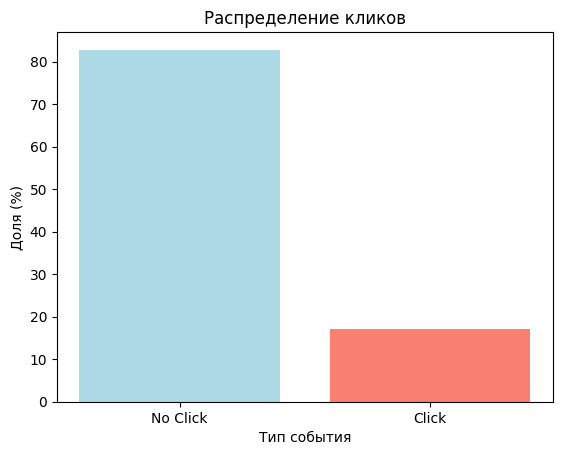

In [12]:
# Подсчетаем количество каждого значения в колонке 'click'
counts = df['click'].value_counts()
percentages = counts / len(df) * 100

# Отображение результатов
print("Процентное соотношение:")
print(percentages)

# Построим столбчатую диаграмму
plt.bar(['No Click', 'Click'], percentages.values, color=['lightblue', 'salmon'])
plt.title('Распределение кликов')
plt.xlabel('Тип события')
plt.ylabel('Доля (%)')
plt.show()

Наблюдается дисбаланс классов целевой переменной: кликов по рекламе значительно меньше, чем просто показов, поэтому стоит внимательно подбирать метрики для оценки качества модели. В нашем случае PR-AUC — основная метрика.

### Анализ признаков
Определим далее, нет ли малозначимых или бесполезных для обучения модели признаков. Сначала опишем категоральные и числовые признаки, затем проведем первичный отбор.

In [13]:
# Выведем статистику .describe() для нашего датафрейма
print(df.describe().T)

                    count          mean           std           min           25%           50%           75%           max
id                50000.0  9.215402e+18  5.328516e+18  3.191077e+13  4.580649e+18  9.243015e+18  1.380920e+19  1.844652e+19
click             50000.0  1.720600e-01  3.774364e-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
hour              50000.0  1.410256e+07  2.967892e+02  1.410210e+07  1.410230e+07  1.410260e+07  1.410281e+07  1.410302e+07
C1                50000.0  1.004970e+03  1.110202e+00  1.001000e+03  1.005000e+03  1.005000e+03  1.005000e+03  1.012000e+03
banner_pos        50000.0  2.913800e-01  5.142013e-01  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  7.000000e+00
device_type       50000.0  1.018120e+00  5.384770e-01  0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  5.000000e+00
device_conn_type  50000.0  3.371600e-01  8.600569e-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  5.000000e+00
C14     

Отметим, что признаки С14 и С20 имеют очень большое стандартное отклонение, далее в проекте поисследуем их подробнее.

Выше мы получили список колонок по типам, будем использовать эту информацию тут.

In [14]:
print("Колонки типа float64:", float_cols)
print("\nКолонки типа int64:", int_cols)
print("\nКолонки типа Object:", obj_cols)

Колонки типа float64: ['id', 'ml_feature_1', 'ml_feature_3', 'ml_feature_5', 'ml_feature_6', 'ml_feature_8', 'ml_feature_9', 'ml_feature_10']

Колонки типа int64: ['click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'ml_feature_4']

Колонки типа Object: ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'ml_feature_2', 'ml_feature_7']


In [15]:
# Выведем уникальные значения в колонках с  типом object
for column in df.select_dtypes(include=['object']).columns:
    unique_values = df[column].unique()
    print(f"Уникальные значения в колонке '{column}' ({len(unique_values)} шт.):")
    print(unique_values)
    print('-' * 50)

Уникальные значения в колонке 'site_id' (1160 шт.):
<StringArray>
['d9750ee7', '1fbe01fe', '85f751fd', '543a539e', 'e59ef3fc', 'e151e245', '5114c672', '0eb72673', 'c63170c5', '518d6168',
 ...
 '8ab5bdcf', 'c52338a7', 'c0d83cac', 'ba85e0e9', '49666f00', 'c306b25a', 'ce5ad4c4', '46e56230', 'ed37f65c', 'a4427a7b']
Length: 1160, dtype: str
--------------------------------------------------
Уникальные значения в колонке 'site_domain' (1013 шт.):
<StringArray>
['98572c79', 'f3845767', 'c4e18dd6', 'c7ca3108', '0a4015b2', '7e091613', '3f2f3819', 'd2f72222', 'a9bba545', '92c9e92d',
 ...
 '64dd1c99', '9e26e486', '00dda4fc', 'c35e5360', '7acc821d', '5e822457', '5675d552', '53175207', '4ebf9b98', '0c34cac9']
Length: 1013, dtype: str
--------------------------------------------------
Уникальные значения в колонке 'site_category' (18 шт.):
<StringArray>
['f028772b', '28905ebd', '50e219e0', '3e814130', '335d28a8', '0569f928', '76b2941d', 'a818d37a', '75fa27f6', 'f66779e6', '70fb0e29', '72722551', 'e7

Есть признаки, которые имеют очень много уникальных значений, например device_id — идентификатор браузера или устройства; device_ip — IP-адрес устройства; Они никак не характеризуют поведение пользователя, затрудняют построение матрицы корреляции, и вероятно, мало влияют на целевую переменную. Можно предположить, что это признаки - кандидаты на удаление. Также удалим колонку id.

In [16]:
# Список колонок для удаления
cols_to_drop = [ 'id', 'device_id','device_ip']
# Удаление указанных колонок из датафрейма
df.drop(columns=cols_to_drop, inplace=True)

Построим матрицу корреляции phik, чтобы оценить взаимосвязь признаков с целевой переменной click. Также построим тепловую карту.

Корреляционная матрица с коэффициентом phi_k для click
interval columns not set, guessing: ['click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'ml_feature_1', 'ml_feature_3', 'ml_feature_4', 'ml_feature_5', 'ml_feature_6', 'ml_feature_8', 'ml_feature_9', 'ml_feature_10']
                     click
hour              0.042935
C1                0.067731
banner_pos        0.022605
site_id           0.336163
site_domain       0.320956
site_category     0.155008
app_id            0.221436
app_domain        0.161289
app_category      0.156537
device_model      0.219222
device_type       0.071790
device_conn_type  0.129954
C14               0.112890
C15               0.106817
C16               0.117539
C17               0.091306
C18               0.257840
C19               0.084697
C20               0.075979
C21               0.166235
ml_feature_1      0.010056
ml_feature_2      0.003790
ml_feature_3      0.000000
ml_

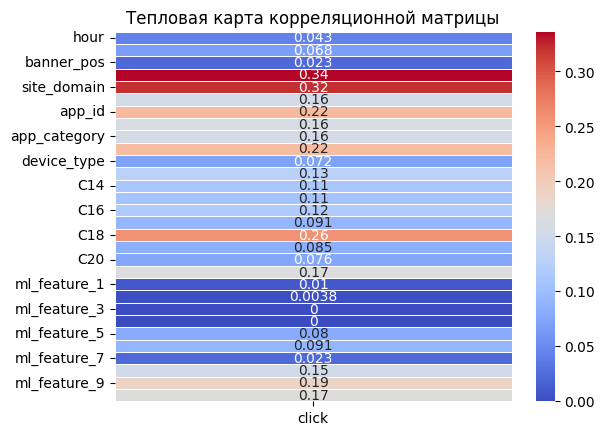

In [17]:
print('Корреляционная матрица с коэффициентом phi_k для click')
correlation_matrix = df.phik_matrix()
correlation_matrix_click=correlation_matrix.loc[correlation_matrix.index != 'click'][['click']]
print(correlation_matrix_click)
# Строим тепловую карту
sns.heatmap(correlation_matrix_click, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Тепловая карта корреляционной матрицы')
plt.show()

Как видно из матрицы корреляции есть признаки, которые совсем не коррелируют с целевой переменной, это ml_feature_3 и ml_feature_4. Посмотрим на них подробнее, возможно, они могут быть тоже удалены из данных при моделировании.

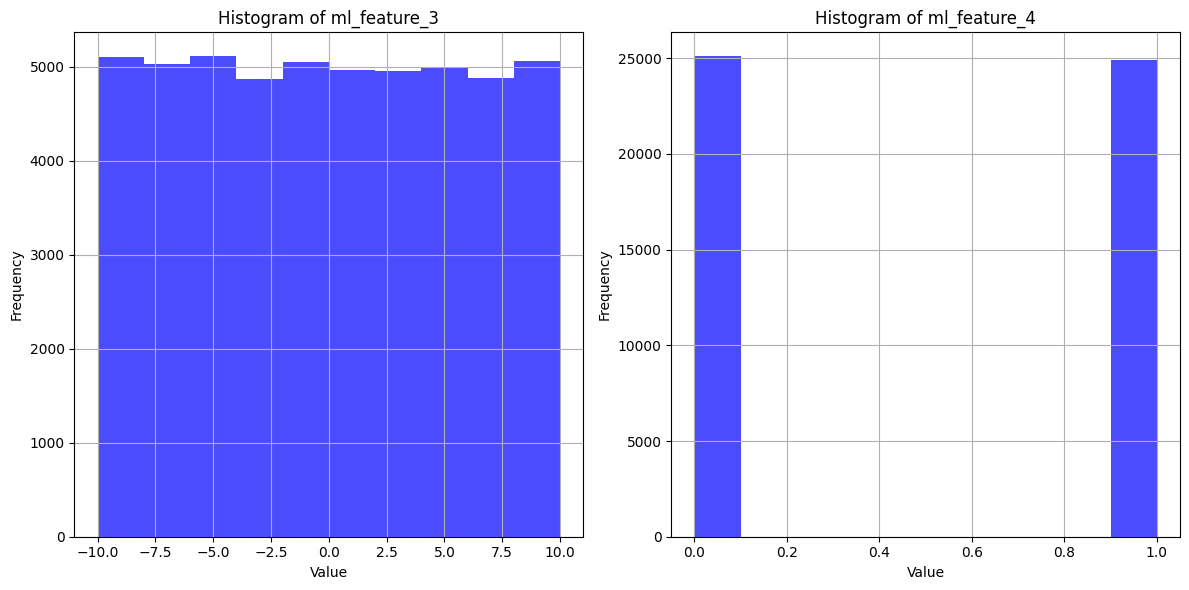

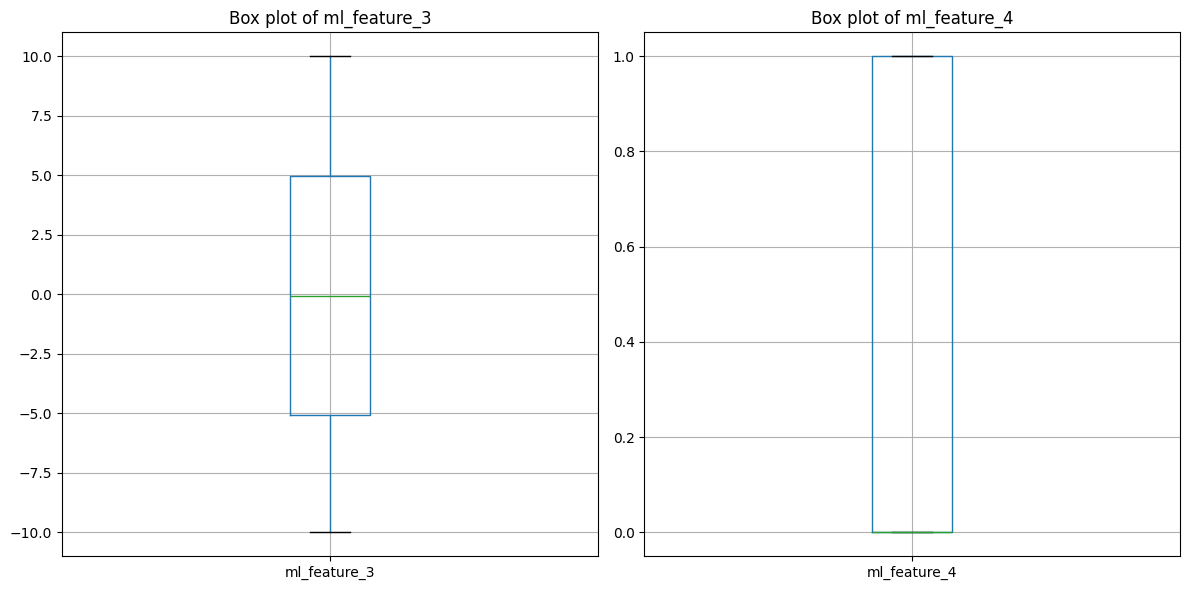

In [18]:
plt.figure(figsize=(12, 6))

# Подграфики (subplots) для обоих признаков
for i, col in enumerate(['ml_feature_3', 'ml_feature_4']):
    plt.subplot(1, 2, i+1)
    df[col].hist(bins=10, alpha=0.7, color='blue')
    plt.title(f'Histogram of {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Боксплот (Box Plot) для каждого признака
plt.figure(figsize=(12, 6))

for i, col in enumerate(['ml_feature_3', 'ml_feature_4']):
    plt.subplot(1, 2, i+1)
    df.boxplot(column=col)
    plt.title(f'Box plot of {col}')

plt.tight_layout()
plt.show()


Как видно из гистограмм, частота значений в колонках почти одинаковая. Похоже, что эти признаки являются техническими и действительно могут быть исключены из моделирования. Построим скаттерплоты для этих признаков и целевой переменной:

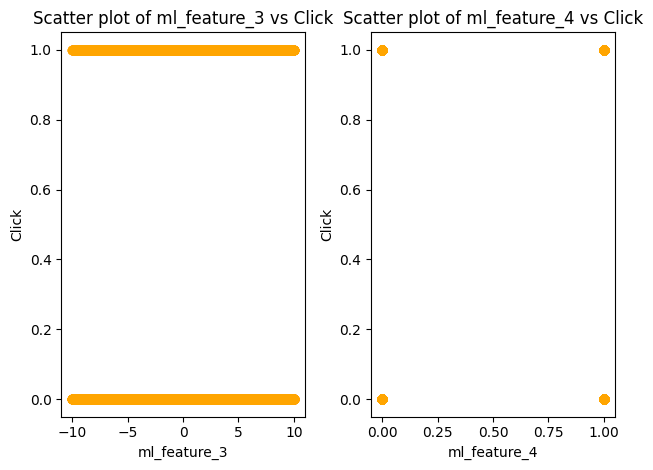

In [19]:
for i, col in enumerate(['ml_feature_3', 'ml_feature_4']):
    plt.subplot(1, 2, i+1)
    plt.scatter(x=df[col], y=df['click'], alpha=0.7, color='orange')
    plt.title(f'Scatter plot of {col} vs Click')
    plt.xlabel(col)
    plt.ylabel('Click')

plt.tight_layout()
plt.show()

Удалим эти признаки, поскольку их корреляиция с целевой переменной минимальна. (Отдельным экспериментом я попробую выполнить моделирование со всеми признаками, чтобы модель сама выделила наименее значимые, но сейчас для экономиии вычислительных ресурсов на основании проведенного анализа я их удалю).

In [20]:
# Список колонок для удаления
cols_to_drop = ['ml_feature_3', 'ml_feature_4']
# Удаление указанных колонок из датафрейма
df.drop(columns=cols_to_drop, inplace=True)

Вернемся к признакам C14 и C20, которые имеют большое стандартное отклонение, посмотрим их распределение и связь с целевой переменной:

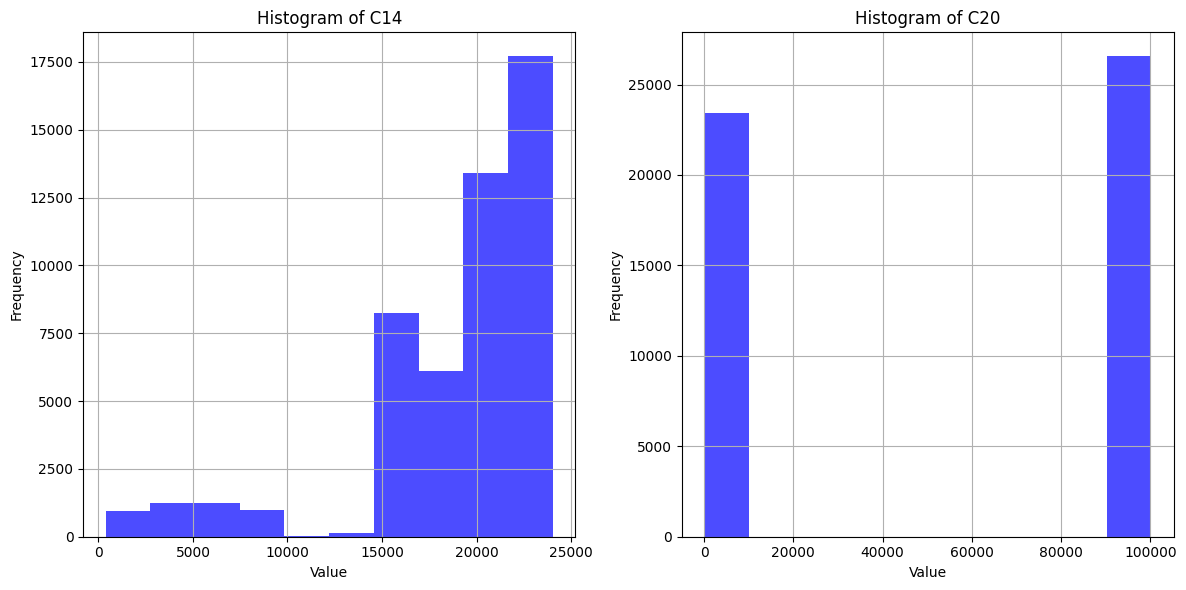

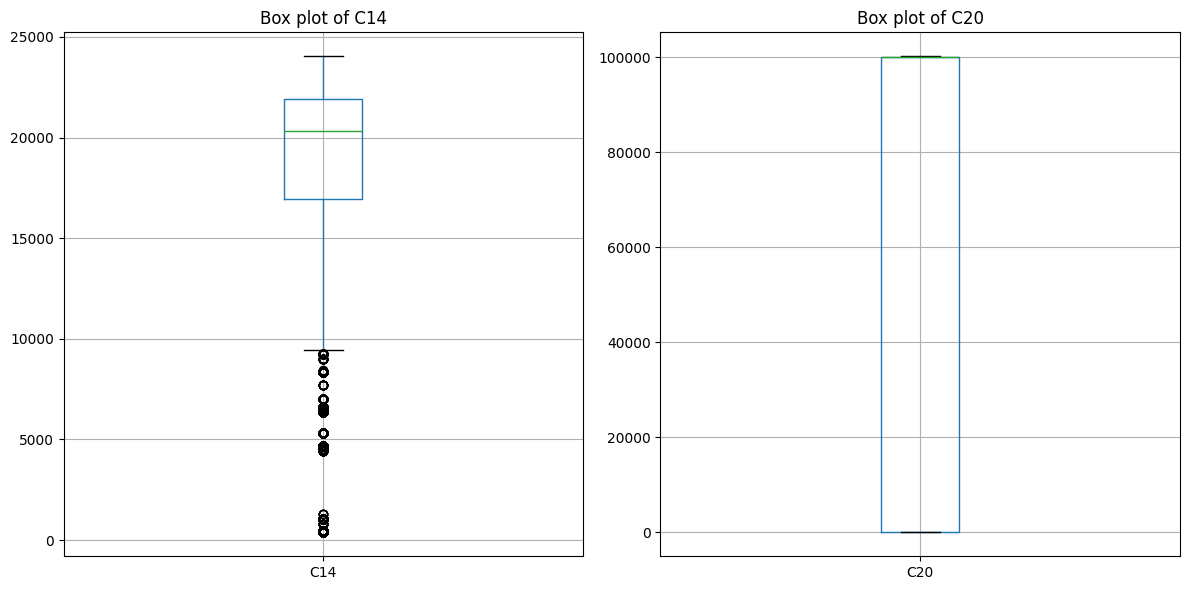

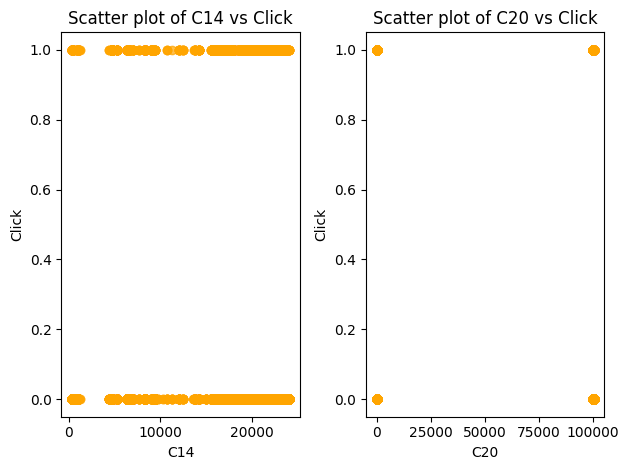

In [21]:
plt.figure(figsize=(12, 6))

# Подграфики (subplots) для обоих признаков
for i, col in enumerate(['C14', 'C20']):
    plt.subplot(1, 2, i+1)
    df[col].hist(bins=10, alpha=0.7, color='blue')
    plt.title(f'Histogram of {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Боксплот (Box Plot) для каждого признака
plt.figure(figsize=(12, 6))

for i, col in enumerate(['C14', 'C20']):
    plt.subplot(1, 2, i+1)
    df.boxplot(column=col)
    plt.title(f'Box plot of {col}')

plt.tight_layout()
plt.show()

for i, col in enumerate(['C14', 'C20']):
    plt.subplot(1, 2, i+1)
    plt.scatter(x=df[col], y=df['click'], alpha=0.7, color='orange')
    plt.title(f'Scatter plot of {col} vs Click')
    plt.xlabel(col)
    plt.ylabel('Click')

plt.tight_layout()
plt.show()

Поскольку мы точно не знаем, какой физический смысл этих признаков, и согласно матрицы корреляции они имеют небольшое влияние на целевую переменную, пока оставим эти признаки, посмотрим в дальнейшем, какие веса им определит модель, хотя признак С20 я бы тоже предложила к исключению. Таким образом на данном этапе мы исключили следующие признаки: 'id', 'device_id', 'device_ip', 'ml_feature_3', 'ml_feature_4'

### Анализ пропущенных значений
Проверим долю пропусков в каждом признаке. При необходимости заполним их, выбрав нужную стратегию: — удаление, среднее, медиана, мода.

Колонки датафрейма не содержат пропусков, но как мы увидели на примере колонки С20 в татафрейме есть определенное число данных, созданных искусственно, возможно с целью заполнения пропусков. Здесь считаю нужным пока не делать никаких дополнительных преобразований, поскольку у части признаков не ясен их физический смысл.

### Анализ категориальных признаков
Определим далее, сколько уникальных значений в каждом категориальном признаке (выше мы уже получали списки этих уникальных значений).
Если значений немного, то к ним можно применить One-Hot Encoding, в ином случае будем использовать специальные методы.

In [22]:
# Подсчет количества уникальных значений в каждом категориальном признаке
for column in df.select_dtypes(include=['object']).columns:
    unique_count = len(df[column].unique())
    print(f"{column}: {unique_count}")

site_id: 1160
site_domain: 1013
site_category: 18
app_id: 976
app_domain: 67
app_category: 22
device_model: 2521
ml_feature_2: 5
ml_feature_7: 3


Видим, что у признаков ml_feature_2, ml_feature_7, site_category уникальных значений немного, их можно кодировать с помощью One-Hot Encoding, для остальных признаков применим кодирование Target Encoding (Метод основан на замене категории средним значением целевой переменной среди всех наблюдений с этой категорией. Риск переобучения (overfitting)в дальнейшем минимизируем путем кросс-валидации и регуляризации). Сформируем соответствующие списки колонок:

In [23]:
cat_ohe_columns = ['ml_feature_2', 'ml_feature_7', 'site_category']
cat_te_columns = ['site_id', 'site_domain', 'app_id', 'app_domain', 'app_category', 'device_model']

### Анализ выбросов и распределений
Проверим, есть ли явные выбросы в числовых признаках. Посмотрим их распределения. Для этого построим ящики с усами и гистограммы распределения для всех числовых признаков датафрейма.

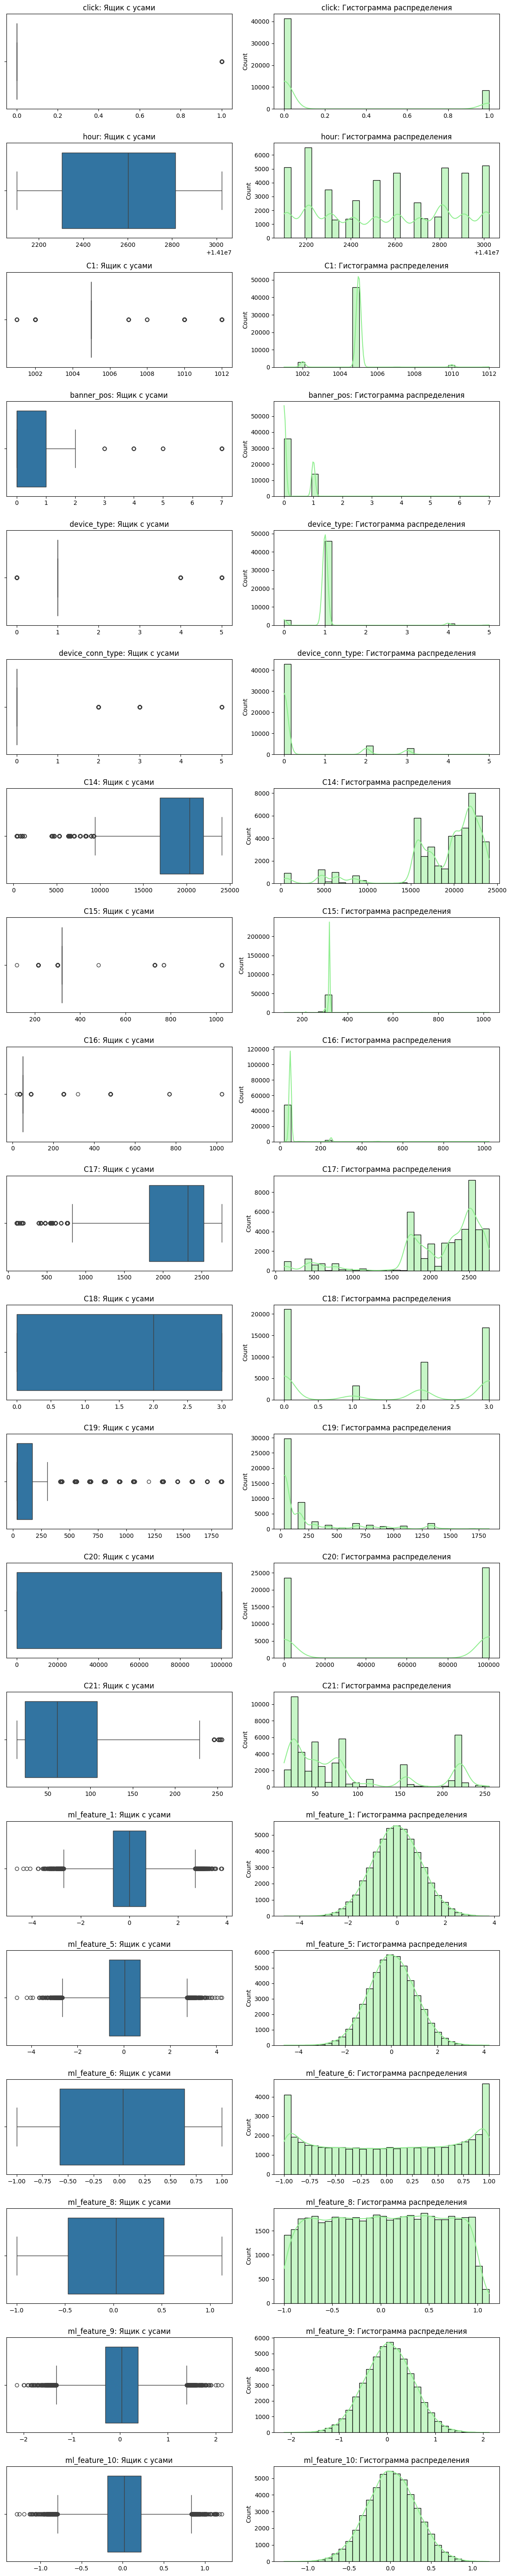

In [24]:
# Выбираем числовые признаки типа int64 и float
numeric_cols = df.select_dtypes(include=['int64', 'float']).columns

# Определяем количество графиков и рассчитываем оптимальное количество рядов
n_rows = len(numeric_cols)

# Настраиваем фигуру с нужным количеством рядов и столбцов
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, n_rows*3))  # две колонки на каждую строку

# Проходим по каждому числовому признаку и рисуем боксплот и гистограмму
for i, col in enumerate(numeric_cols):
    # Боксплот
    sns.boxplot(data=df, x=col, ax=axes[i][0])
    axes[i][0].set_title(f'{col}: Ящик с усами')
    axes[i][0].set_xlabel('')  # Убираем подпись осей X
    
    # Гистограмма
    sns.histplot(data=df, x=col, kde=True, bins=30, color="lightgreen", ax=axes[i][1])  # добавляем KDE кривую
    axes[i][1].set_title(f'{col}: Гистограмма распределения')
    axes[i][1].set_xlabel('')  # Убираем подпись осей X

plt.tight_layout()
plt.show()

Проанализировав боксплоты, можно увидеть, что некоторые признаки меют выбросы, распределение отклонено влево, например как у С14 и С17, вправо, как например, С19 и С21 или же выбросы есть и слева и справа. Поскольку у части признаков мы не знаем физического смысла, и в принципе будем нормализовать признаки, то выбросы здесь обрабатывать не станем.

###  Корреляции
Выше мы определили признаки, которые не коррелируют с целевой переменной и удалили их. Отметим  признаки, которые имеют наиболее сильную корреляцию со значением целевой переменной. На основе выше построенной матрицы корреляции - это: 

site_id           0.336163  
site_domain       0.320956  
site_category     0.155008  
app_id            0.221436  
app_domain        0.161289  
app_category      0.156537  
device_model      0.219222  
C18               0.257840  
Как видим, корреляция отдельных признаков с целевой переменной не сильно велика.

Попробуем также найти сильно скоррелированные признаки, если такие есть. В дальнейшем их можно будет также удалить.

In [25]:
strong_correlations = []
threshold = 0.9

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)): # Избегаем повторений и диагональ
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature_1 = correlation_matrix.columns[i]
            feature_2 = correlation_matrix.columns[j]
            corr_value = round(abs(correlation_matrix.iloc[i, j]), 3)
            strong_correlations.append((feature_1, feature_2, corr_value))

if not strong_correlations:
    print("Нет пар признаков с сильной корреляцией.")
else:
    result_df = pd.DataFrame(strong_correlations, columns=['Признак 1', 'Признак 2', 'Корреляция'])
    print(result_df.sort_values(by='Корреляция', ascending=False))  # Сортируем по убыванию силы корреляции

       Признак 1         Признак 2  Корреляция
11        app_id      app_category       1.000
10        app_id        app_domain       1.000
5        site_id       site_domain       1.000
6        site_id     site_category       1.000
9    site_domain      device_model       0.999
7        site_id      device_model       0.999
12        app_id      device_model       0.998
8    site_domain     site_category       0.995
17    app_domain      device_model       0.993
21           C14               C17       0.987
0             C1            app_id       0.978
1             C1      device_model       0.968
20  device_model  device_conn_type       0.964
19  device_model       device_type       0.960
14        app_id  device_conn_type       0.959
3     banner_pos           site_id       0.954
16    app_domain      app_category       0.940
4     banner_pos       site_domain       0.925
2             C1       device_type       0.924
15        app_id               C15       0.920
13        app

Как видим, часть признаков сильно коррелирует между собой, например у следующих пар корреляция = 1:  
site_id site_domain 1.000  
site_id site_category 1.000  
app_id app_domain 1.000  
app_id app_category 1.000  
Это признаки:  
Характеристики рекламной площадки ( Site ):  
site_id — идентификатор веб-сайта, на котором был показан баннер;  
site_domain — домен веб-сайта;  
site_category — тематическая категория веб-сайта.  
Характеристики рекламируемого приложения ( App ):  
app_id — идентификатор рекламируемого мобильного приложения;  
app_domain — домен рекламируемого приложения;  
app_category — категория рекламируемого приложения.  
Думаю, что признаки site_domain, site_category, app_domain, app_category можно удалить (сначала планировала удалить site_id, app_id, но у них корреляция с целевой переменной самая сильная, поэтому удалим коррелированные с ними признаки). Остальные признаки тоже имеют сильную корреляцию, но пока их оставим.



In [26]:
# Список колонок для удаления
cols_to_drop = ['site_domain', 'site_category', 'app_domain', 'app_category']
# Проверяем существование каждого столбца перед удалением
for col in cols_to_drop:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)
    else:
        print(f'Колонка "{col}" отсутствует в датафрейме.')


### Выводы по EDA
Итак, мы установили, что признаки по отдельности мало коррелируют с целевой переменной. Зато выявили те, которые сильно коррелируют между собой, эти признаки мы удалили.
Наи
Выберите признаки, которые выглядят наиболее перспективными для модели. Выбор обоснуйте.
Определите действия по предобработке данных, которые необходимо проделать.

## Разделение данных на выборки
Отделим от данных целевую переменную и разделим их на выборки - train, calib и test в соотношении 60%\20%\20%. Будем использовать стратифицированное разделение, чтобы сохранить баланс классов.
После разделения проверим, что распределение целевой переменной сохранено в каждой выборке.

In [27]:
# Отделяем признаки и целевую переменную
X = df.drop(columns=['click'])  
y = df['click']

# Разделение на temp и test (80% / 20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=RANDOM_SEED
)

# Разделение оставшихся данных на train и calibration (60% / 20% от общего)
X_train, X_calib, y_train, y_calib = train_test_split(
    X_temp, y_temp, test_size=0.25, shuffle=True, stratify=y_temp, random_state=RANDOM_SEED
)

# Проверка размеров выборок
print(f"Train размер: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Calibration размер: {len(X_calib)} ({len(X_calib)/len(X)*100:.1f}%)")
print(f"Test размер: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"Соотношение классов в train: {np.bincount(y_train)}")
print(f"Соотношение классов в calib: {np.bincount(y_calib)}")
print(f"Соотношение классов в test: {np.bincount(y_test)}")


# Распределение целевой переменной click в процентах
def distribution_report(y_data):
    total_count = len(y_data)
    class_counts = np.bincount(y_data.astype(int))
    
    print(f"Класс 0: {class_counts[0]} ({class_counts[0]/total_count*100:.2f}%)")
    print(f"Класс 1: {class_counts[1]} ({class_counts[1]/total_count*100:.2f}%)\n")

# Выведем статистику целевой перемнной для обеих выборок
print('Распределение click в тренировочном наборе:')
distribution_report(y_train)
print('Распределение click в калибровочном наборе:')
distribution_report(y_test)
print('Распределение click в тестовом наборе:')
distribution_report(y_test)

Train размер: 30000 (60.0%)
Calibration размер: 10000 (20.0%)
Test размер: 10000 (20.0%)
Соотношение классов в train: [24838  5162]
Соотношение классов в calib: [8280 1720]
Соотношение классов в test: [8279 1721]
Распределение click в тренировочном наборе:
Класс 0: 24838 (82.79%)
Класс 1: 5162 (17.21%)

Распределение click в калибровочном наборе:
Класс 0: 8279 (82.79%)
Класс 1: 1721 (17.21%)

Распределение click в тестовом наборе:
Класс 0: 8279 (82.79%)
Класс 1: 1721 (17.21%)



Мы убедились, что распределение целевой переменной во всех трех выборках сохранено.

## Предобработка данных — построение пайплайнов
### Создание пайплайна для предобработки данных
Для числовых признаков выполним масштабирование данных с помощью StandardScaler.

Для категориальных признаков применим кодирование:  
One-Hot Encoding для признаков с малой кардинальностью.
Target Encoding для признаков с высокой кардинальностью.
    Списки признаков мы уже получили выше:  
    cat_ohe_columns = ['ml_feature_2', 'ml_feature_7', 'site_category']  
cat_te_columns = ['site_id', 'site_domain', 'app_id', 'app_domain', 'app_category', 'device_model'] но часть признаков мы удалили на этапе оценки их корреляции друг с другом

In [36]:
# Делим признаки на числовые и категориальные
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
#categorical_features = df.select_dtypes(include=['object']).columns.tolist()
cat_ohe_columns = ['ml_feature_2', 'ml_feature_7']
cat_te_columns = ['site_id', 'app_id','device_model']



In [37]:

# Предобработка данных
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_ohe', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_ohe_columns),
         ('cat_te', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('targetenc', TargetEncoder())
       ]), cat_te_columns),
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features)
    ],
    remainder='drop'
)


In [38]:
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)

In [39]:
feature_names = preprocessor.get_feature_names_out()

In [40]:
print(feature_names)

['cat_ohe__ml_feature_2_A' 'cat_ohe__ml_feature_2_B'
 'cat_ohe__ml_feature_2_C' 'cat_ohe__ml_feature_2_D'
 'cat_ohe__ml_feature_2_E' 'cat_ohe__ml_feature_7_X'
 'cat_ohe__ml_feature_7_Y' 'cat_ohe__ml_feature_7_Z' 'cat_te__0'
 'cat_te__1' 'cat_te__2' 'num__hour' 'num__C1' 'num__banner_pos'
 'num__device_type' 'num__device_conn_type' 'num__C14' 'num__C15'
 'num__C16' 'num__C17' 'num__C18' 'num__C19' 'num__C20' 'num__C21'
 'num__ml_feature_1' 'num__ml_feature_5' 'num__ml_feature_6'
 'num__ml_feature_8' 'num__ml_feature_9' 'num__ml_feature_10']


Был создан пайплайн для предобработки числовых и категоральных признаков.

## Отбор признаков

### Применим фильтрационные методы
- Посчитаем корреляцию каждого признака с целевой переменной.
- Отберем топ лучших признаков. 
- Удалим признаки с очень низкой вариацией `VarianceThreshold`.

### Применим методы-обёртки
- Используйте методы-обёртки для поиска оптимального набора признаков.

### Выберем финальный набор признаков
- Объединим результаты методов.
- Выберем признаки, которые прошли фильтрацию.

Выше в работе мы удалили часть признаков, которые мало коррелируют с целевой переменной и те, которые сильно коррелируют между собой. Далее попробуем найти и удалить признаки с очень низкой вариацией `VarianceThreshold`, а также применить методы - обертки для отбора признаков.



In [41]:
# Удаляем числовые квази-константные признаки (threshold=0.90)
vs_quasi = VarianceThreshold(threshold=0.10) 
numerical_columns = X_train.select_dtypes(include=[np.number]).columns
numerical_data = X_train[numerical_columns]
vs_quasi.fit(numerical_data)
quasi_num_cols = [col for col, keep in zip(numerical_columns, vs_quasi.get_support()) if not keep]

# Квази-константные категориальные признаки
quasi_cat_cols = [col for col in X_train.select_dtypes(include=['object']).columns
                  if X_train[col].value_counts(normalize=True).iloc[0] > 0.90]

# Объединяем
quasi_constant_cols = quasi_num_cols + quasi_cat_cols
print("Квази-константные признаки для удаления:", quasi_constant_cols)

Квази-константные признаки для удаления: ['ml_feature_10']


Далее попробуем отобрать признаки с помощью метода - обертки:

In [43]:
#  Функция для отбора признаков - универсальная обёртка, которая стандартизирует вызов рекурсивного, прямого и обратного отбора признаков.
def wrapper_selection(method_name, estimator, X, y, feature_names, k=(1, 10), forward=True, rfe_k=None):
    start_time = time()
    if method_name == 'RFE':
        selector = RFE(estimator, n_features_to_select=rfe_k)
        selector.fit(X, y)
        selected_idx = selector.support_
    else:
        selector = SFS(estimator, k_features=k, forward=forward, scoring=scoring_metric, cv=None, n_jobs=-1)
        selector.fit(X, y)
        selected_idx = list(selector.k_feature_idx_)

    elapsed = time() - start_time
    selected_features = np.array(feature_names)[selected_idx]
    return selected_features, elapsed

# Методы отбора признаков
# ====================================================
lr_estimator = LogisticRegression(max_iter=5000, random_state=42)
svc_evaluator = SVC(probability=True, random_state=42)
cv_splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring_metric = 'accuracy'

# ====================================================
# Запуск методов отбора: wrapper_selection скрытая функция, где применяется метод отбора selector.fit(X, y)
# ====================================================
forward_features, forward_time = wrapper_selection('SFS', lr_estimator, X_train_preprocessed, y_train, feature_names, k=(1, 10), forward=True)
backward_features, backward_time = wrapper_selection('SFS', lr_estimator, X_train_preprocessed, y_train, feature_names, k=(1, 10), forward=False)
rfe_features, rfe_time = wrapper_selection('RFE', lr_estimator, X_train_preprocessed, y_train, feature_names, rfe_k=10)


In [44]:
def build_pipeline(selected_features, method_name):
    feature_names_all = list(preprocessor.get_feature_names_out())
    selected_indices = [feature_names_all.index(f) for f in selected_features]

    selector = FunctionTransformer(lambda X: X[:, selected_indices], validate=False)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('model', SVC(probability=True, random_state=42))
    ])

    score = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv_splitter, n_jobs=-1).mean()
    return pipeline, score

final_pipelines = {}
final_scores = {}

final_pipelines['Forward'], final_scores['Forward'] = build_pipeline(forward_features, 'Forward Selection')

final_pipelines['Backward'], final_scores['Backward'] = build_pipeline(backward_features, 'Backward Elimination')

final_pipelines['RFE'], final_scores['RFE'] = build_pipeline(rfe_features, 'RFE')

# ====================================================
methods = [
    ('Forward Selection', forward_features, forward_time, final_scores['Forward']),
    ('Backward Elimination', backward_features, backward_time, final_scores['Backward']),
    ('RFE', rfe_features, rfe_time, final_scores['RFE'])
]

# Создание DataFrame 
results_df = pd.DataFrame([
    {'Method': name, 'Features Count': len(features), 'Time (s)': t, 'Pipeline Accuracy': score}
    for name, features, t, score in methods
])

results_df['Pipeline Accuracy'] = results_df['Pipeline Accuracy'].map('{:.4f}'.format)
results_df['Time (s)'] = results_df['Time (s)'].map('{:.2f}'.format)

print("\n=== Сводная Таблица Результатов ===")
print(results_df.to_string(index=False))

# Лучшая стратегия
best_method = results_df.sort_values('Pipeline Accuracy', ascending=False).iloc[0]['Method']
print(f"\n Лучшая стратегия: {best_method}")

# Печать выбранных признаков для каждого метода
for name, features, _, _ in methods:
    print(f"\n Выбрано признаков {name}: {len(features)}")
    print(" Список выбранных признаков:")
    print("  • " + "\n  • ".join(features))


=== Сводная Таблица Результатов ===
              Method  Features Count Time (s) Pipeline Accuracy
   Forward Selection              10     8.34            0.8290
Backward Elimination              10    46.51            0.8310
                 RFE              10     3.73            0.8279

 Лучшая стратегия: Backward Elimination

 Выбрано признаков Forward Selection: 10
 Список выбранных признаков:
  • cat_ohe__ml_feature_2_A
  • cat_ohe__ml_feature_2_B
  • cat_te__0
  • cat_te__1
  • cat_te__2
  • num__banner_pos
  • num__ml_feature_5
  • num__ml_feature_6
  • num__ml_feature_9
  • num__ml_feature_10

 Выбрано признаков Backward Elimination: 10
 Список выбранных признаков:
  • cat_ohe__ml_feature_2_B
  • cat_ohe__ml_feature_7_Z
  • cat_te__0
  • cat_te__1
  • cat_te__2
  • num__ml_feature_5
  • num__ml_feature_6
  • num__ml_feature_8
  • num__ml_feature_9
  • num__ml_feature_10

 Выбрано признаков RFE: 10
 Список выбранных признаков:
  • cat_ohe__ml_feature_2_A
  • cat_ohe__ml_feat

Итак, отбор квази константных признаков показал, что признаком для удаления может стать: ['ml_feature_10'] 
    Поскольку у метода Backward Elimination accuracy оказалась больше всех, 0.8310, то я буду опираться на этот список признаков, учитывая, что подбор признаков я производила  по предобработанным колонкам. Плюс добавлю некоторые признаки из выбранных другими методами. И оставлю признаки, коррелирующие с целевой переменной, как мы нашли выше. 

Удалим остальные признаки по итогам отбора:

In [45]:
columns_list = X_train.columns.tolist()
print(columns_list) 

['hour', 'C1', 'banner_pos', 'site_id', 'app_id', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'ml_feature_1', 'ml_feature_2', 'ml_feature_5', 'ml_feature_6', 'ml_feature_7', 'ml_feature_8', 'ml_feature_9', 'ml_feature_10']


In [47]:
# Список колонок для удаления
cols_to_drop = ['C1', 'hour', 'device_conn_type','device_type', 'ml_feature_1','C14','C15','C16','C17', 'C19','C20','C21']
# Проверяем существование каждого столбца перед удалением
for col in cols_to_drop:
    if col in X_train.columns:
        X_calib.drop(col, axis=1, inplace=True)
        X_test.drop(col, axis=1, inplace=True)
        X_train.drop(col, axis=1, inplace=True)
    else:
        print(f'Колонка "{col}" отсутствует в датафрейме.')


Колонка "C1" отсутствует в датафрейме.
Колонка "hour" отсутствует в датафрейме.
Колонка "device_conn_type" отсутствует в датафрейме.
Колонка "device_type" отсутствует в датафрейме.
Колонка "ml_feature_1" отсутствует в датафрейме.
Колонка "C14" отсутствует в датафрейме.
Колонка "C15" отсутствует в датафрейме.
Колонка "C16" отсутствует в датафрейме.
Колонка "C17" отсутствует в датафрейме.
Колонка "C19" отсутствует в датафрейме.
Колонка "C20" отсутствует в датафрейме.
Колонка "C21" отсутствует в датафрейме.


Итого, по итогам отбора признаков у нас остались следующие признаки:

In [56]:
columns_list = X_train.columns.tolist()
print(columns_list) 

['banner_pos', 'site_id', 'app_id', 'device_model', 'C18', 'ml_feature_2', 'ml_feature_5', 'ml_feature_6', 'ml_feature_7', 'ml_feature_8', 'ml_feature_9', 'ml_feature_10']


In [63]:
# Переопроеделим признаки после удаления  -  числовые и категориальные
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
cat_ohe_columns = ['ml_feature_2', 'ml_feature_7']
cat_te_columns = ['site_id', 'app_id','device_model']
print(numerical_features)
print(cat_ohe_columns)
print(cat_te_columns)

['banner_pos', 'C18', 'ml_feature_5', 'ml_feature_6', 'ml_feature_8', 'ml_feature_9', 'ml_feature_10']
['ml_feature_2', 'ml_feature_7']
['site_id', 'app_id', 'device_model']


Перестроим препроцессор:

In [64]:
# Предобработка данных
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_ohe', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_ohe_columns),
         ('cat_te', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('targetenc', TargetEncoder())
       ]), cat_te_columns),
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features)
    ],
    remainder='drop'
)


## Обучение базовой модели

### Обучение `DummyClassifier`
Чтобы обозначить самый простой базовый уровень работы модели, создадим DummyClassifier.



In [65]:
# Создание экземпляра модели DummyClassifier
dummy_classifier = DummyClassifier(strategy="most_frequent")  # самая простая стратегия предсказания наиболее частого класса

# Обучение модели на тренировочной выборке
dummy_classifier.fit(X_train, y_train)

# Прогнозирование классов на тестовых данных
predictions = dummy_classifier.predict(X_test)

# Оценка качества модели
print("Classification Report - dummy:\\n", classification_report(y_test, predictions))


Classification Report - dummy:\n               precision    recall  f1-score   support

           0       0.83      1.00      0.91      8279
           1       0.00      0.00      0.00      1721

    accuracy                           0.83     10000
   macro avg       0.41      0.50      0.45     10000
weighted avg       0.69      0.83      0.75     10000



Для класса 0 (негативный/основной класс):
Precision = 0.83 — Из всех предсказаний "0", 83% действительно класс 0

Это просто доля класса 0 в данных (8279/10000 ≈ 0.83)

Recall = 1.00 — Найден 100% реальных объектов класса 0

Потому что модель ВСЕ предсказывает как 0

F1-score = 0.91 — Гармоническое среднее precision и recall

Для класса 1 (позитивный/миноритарный класс):
Precision = 0.00 — Модель НИКОГДА не предсказывает класс 1

Recall = 0.00 — Модель НЕ НАШЛА ни одного реального объекта класса 1

F1-score = 0.00 — Оба компонента нулевые

### Обучение `LogisticRegression`
Обучим LogisticRegression, используем для обучения отобранные признаки.
Применим кросс-валидацию на 5 фолдах.
Посчитаем метрику PR-AUC. Дополнительно рассчитаем Precision, Recall и F1-score.



In [70]:
print(preprocessor.transformers)

for name, transformer, columns in preprocessor.transformers:
    print(f"Transformer '{name}' работает с колонками: {columns}")

[('cat_ohe', Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), ['ml_feature_2', 'ml_feature_7']), ('cat_te', Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('targetenc', TargetEncoder())]), ['site_id', 'app_id', 'device_model']), ('num', Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]), ['banner_pos', 'C18', 'ml_feature_5', 'ml_feature_6', 'ml_feature_8', 'ml_feature_9', 'ml_feature_10'])]
Transformer 'cat_ohe' работает с колонками: ['ml_feature_2', 'ml_feature_7']
Transformer 'cat_te' работает с колонками: ['site_id', 'app_id', 'device_model']
Transformer 'num' работает с колонками: ['banner_pos', 'C18', 'ml_feature_5', 'ml_feature_6', 'ml_feature_8', 'ml_feature_9', 'ml_feature_10']


In [71]:
N_FOLDS = 5
log_reg_model_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_SEED, max_iter=1000))
])

# Кросс-валидация на 5 фолдов
kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# Выполняем кросс-валидацию
results = cross_validate(log_reg_model_pipe, 
                         X=X_train,  
                         y=y_train, 
                         cv=kf, 
                         scoring=['precision', 'recall', 'f1'], 
                         return_estimator=True, 
                         return_train_score=False)

# Вычисляем PR-AUC
pr_auc_scores = []
for fold_num, est in enumerate(results['estimator']):
    probas = est.predict_proba(X_train)[:, 1]
    precisions, recalls, _ = precision_recall_curve(y_train, probas)
    pr_auc = auc(recalls, precisions)
    pr_auc_scores.append(pr_auc)

# Среднее значение метрик
mean_precision = results['test_precision'].mean()
mean_recall = results['test_recall'].mean()
mean_f1 = results['test_f1'].mean()
mean_pr_auc = np.mean(pr_auc_scores)

# Выводим результаты
print(f"Средняя точность (Precision): {mean_precision:.4f}")
print(f"Средняя полнота (Recall): {mean_recall:.4f}")
print(f"Средний F1-score: {mean_f1:.4f}")
print(f"Средний PR-AUC: {mean_pr_auc:.4f}")

Средняя точность (Precision): 0.5677
Средняя полнота (Recall): 0.1492
Средний F1-score: 0.2362
Средний PR-AUC: 0.4524


### Обучение `SVC`
Обучим далее SVC с линейным ядром.
Применим кросс-валидацию на 5 фолдах и посчитаем ту же метрику PR-ROC. Дополнительно рассчитаем Precision, Recall и F1-score

In [75]:
N_FOLDS = 5
# Base model SVC
base_model_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=RANDOM_SEED, probability=True))
])
# Кросс-валидация на 5 фолдов
kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# Выполняем кросс-валидацию
results = cross_validate(base_model_pipe, 
                         X=X_train,  # Используем только выбранные признаки
                         y=y_train, 
                         cv=kf, 
                         scoring=['precision', 'recall', 'f1'], 
                         return_estimator=True, 
                         return_train_score=False)

# Вычисляем PR-AUC
pr_auc_scores = []
for fold_num, est in enumerate(results['estimator']):
    probas = est.predict_proba(X_train)[:, 1]
    precisions, recalls, _ = precision_recall_curve(y_train, probas)
    pr_auc = auc(recalls, precisions)
    pr_auc_scores.append(pr_auc)

# Среднее значение метрик
mean_precision = results['test_precision'].mean()
mean_recall = results['test_recall'].mean()
mean_f1 = results['test_f1'].mean()
mean_pr_auc = np.mean(pr_auc_scores)

# Выводим результаты
print(f"Средняя точность (Precision): {mean_precision:.4f}")
print(f"Средняя полнота (Recall): {mean_recall:.4f}")
print(f"Средний F1-score: {mean_f1:.4f}")
print(f"Средний PR-AUC: {mean_pr_auc:.4f}")

Средняя точность (Precision): 0.7253
Средняя полнота (Recall): 0.0182
Средний F1-score: 0.0355
Средний PR-AUC: 0.4948


### Сравнение моделей
Выпишем полученные результаты:  
*Dummy*  
               precision    recall  f1-score   support  
           0       0.83      1.00      0.91      8279  
           1       0.00      0.00      0.00      1721  
    -accuracy                           0.83     10000  
   -macro avg       0.41      0.50      0.45     10000  
-weighted avg       0.69      0.83      0.75     10000  

*Logistic Regression*  
-Средняя точность (Precision): 0.5677  
-Средняя полнота (Recall): 0.1492  
-Средний F1-score: 0.2362  
-Средний PR-AUC: 0.4524  

*SVC*  
-Средняя точность (Precision): 0.7253  
-Средняя полнота (Recall): 0.0182  
-Средний F1-score: 0.0355  
-Средний PR-AUC: 0.4948  

Проанализировав метрики моделей, мы увидели, что `LogisticRegression` работает лучше `DummyClassifier`, но при этом она уступает `SVC` по PR-AUC. Попробуем далее подобрать гиперпараметры для моделей.

## Подбор гиперпараметров: Grid Search с кросс-валидацией

###  Определение сетки гиперпараметров
Определим ключевые параметры, которые влияют на качество моделей LogisticRegression и SVC.

In [89]:
# Параметры для GridSearch - Оставим минимум, потом можно будет расширить вариации
param_grid_lr = {
    'logisticregression__C': [0.01, 0.1, 1, 10], 
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__max_iter': [1000]
}

param_grid_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.001, 0.01, 0.1],
    'svc__kernel': ['linear', 'rbf']
}

### Применение Grid Search
Используем GridSearchCV для перебора всех комбинаций. Установим scoring='average_precision'. Выведим лучшие параметры и их метрики.

In [90]:
# Настройка конвейера
pipe_lr = make_pipeline(preprocessor, LogisticRegression(solver='liblinear', random_state=42))
pipe_svc = make_pipeline(preprocessor, SVC(random_state=42, probability=True))



# Создаем GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid_lr,
    scoring='average_precision',  # или 'roc_auc', 'f1', 'accuracy'
    cv=5,
    n_jobs=-1,
    verbose=2,  # более подробный вывод
    refit=True,
    error_score='raise'  # поднимает ошибку если что-то не так
)

grid_search_svc = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid_svc,
    scoring='average_precision',
    cv=5,
    n_jobs=-1,
    verbose=2,
    refit=True,
    error_score='raise'
)
# Обучение с поиском лучших параметров
print("="*60)
print("Поиск лучших параметров для LogisticRegression")
print("="*60)
grid_search_lr.fit(X_train, y_train)

print("\n" + "="*60)
print("Поиск лучших параметров для SVC")
print("="*60)
grid_search_svc.fit(X_train, y_train)

# Результаты
print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ")
print("="*60)

print("\nЛучшая модель LogisticRegression:")
print(f"Параметры: {grid_search_lr.best_params_}")
print(f"Лучший score (AP): {grid_search_lr.best_score_:.4f}")

print("\nЛучшая модель SVC:")
print(f"Параметры: {grid_search_svc.best_params_}")
print(f"Лучший score (AP): {grid_search_svc.best_score_:.4f}")



Поиск лучших параметров для LogisticRegression
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Поиск лучших параметров для SVC
Fitting 5 folds for each of 18 candidates, totalling 90 fits

РЕЗУЛЬТАТЫ

Лучшая модель LogisticRegression:
Параметры: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2'}
Лучший score (AP): 0.4033

Лучшая модель SVC:
Параметры: {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Лучший score (AP): 0.3780


### Таблица результатов
Составим таблицу и покажем топ-10 конфигураций с их метриками.

In [91]:
#  Лучшие параметры и метрики
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

best_params_svc = grid_search_svc.best_params_
best_score_svc = grid_search_svc.best_score_

print("Лучший score для Logistic Regression:", best_score_lr)
print("Лучшие параметры для Logistic Regression:", best_params_lr)

print("Лучший score для SVM:", best_score_svc)
print("Лучшие параметры для SVM:", best_params_svc)

# Формирование таблицы лучших результатов
# Получение результатов поиска по сетке
results_df_lr = pd.DataFrame(grid_search_lr.cv_results_)
results_df_svc = pd.DataFrame(grid_search_svc.cv_results_)

# Топ-10 лучших конфигураций
top_results_lr = results_df_lr.sort_values(by='rank_test_score').head(10)
top_results_svc = results_df_svc.sort_values(by='rank_test_score').head(10)

# Отображение таблиц
print("Топ-10 конфигураций для Logistic Regression:")
display(top_results_lr[['params', 'mean_test_score', 'std_test_score']])

print("Топ-10 конфигураций для SVM:")
display(top_results_svc[['params', 'mean_test_score', 'std_test_score']])

Лучший score для Logistic Regression: 0.40326817652544855
Лучшие параметры для Logistic Regression: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2'}
Лучший score для SVM: 0.3780176042898636
Лучшие параметры для SVM: {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Топ-10 конфигураций для Logistic Regression:


,params,mean_test_score,std_test_score
3,"{'logisticregression__C': 0.1, 'logisticregres...",0.403268,0.013603
2,"{'logisticregression__C': 0.1, 'logisticregres...",0.394579,0.012980
5,"{'logisticregression__C': 1, 'logisticregressi...",0.394409,0.012545
4,"{'logisticregression__C': 1, 'logisticregressi...",0.391834,0.012350
7,"{'logisticregression__C': 10, 'logisticregress...",0.391831,0.012336
6,"{'logisticregression__C': 10, 'logisticregress...",0.391482,0.012309
0,"{'logisticregression__C': 0.01, 'logisticregre...",0.391150,0.015692
1,"{'logisticregression__C': 0.01, 'logisticregre...",0.364672,0.014671


Топ-10 конфигураций для SVM:


,params,mean_test_score,std_test_score
15,"{'svc__C': 10, 'svc__gamma': 0.01, 'svc__kerne...",0.378018,0.014011
9,"{'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel...",0.377747,0.014233
3,"{'svc__C': 0.1, 'svc__gamma': 0.01, 'svc__kern...",0.367559,0.010823
13,"{'svc__C': 10, 'svc__gamma': 0.001, 'svc__kern...",0.366835,0.015541
0,"{'svc__C': 0.1, 'svc__gamma': 0.001, 'svc__ker...",0.366827,0.016169
2,"{'svc__C': 0.1, 'svc__gamma': 0.01, 'svc__kern...",0.366827,0.016169
4,"{'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kerne...",0.366827,0.016169
11,"{'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel'...",0.365020,0.015119
5,"{'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kerne...",0.364494,0.015810
17,"{'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel...",0.358310,0.017502


## Финальная модель

#### Обучение финальной модели
Для обучения финальной модели используем лучшие параметры из Grid Search. Обучим модель на всей обучающей выборке.


Выше мы получили:  
Лучший score для Logistic Regression: 0.40326817652544855  
Лучшие параметры для Logistic Regression: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2'}  
Лучший score для SVM: 0.3780176042898636  
Лучшие параметры для SVM: {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}  

In [96]:

X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Обучение финальной модели SVM с оптимальными гиперпараметрами
best_params = {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
final_model = SVC(C=10, gamma=0.01, kernel='rbf', probability=True) # Включаем вычисление вероятности
final_model.fit(X_train_preprocessed, y_train)

# Получение вероятностей для теста
y_pred_proba = final_model.predict_proba(X_test_preprocessed)[:, 1]




### Расчет метрик на тестовой выборке
Рассчитаем следующие метрики на тестовый выборке:
  - PR-AUC.  
  - Оценка Бриера.  
  - Дополнительные метрики при необходимости.  



In [101]:
# Расчет PR-AUC и Brier score
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
brier_score = brier_score_loss(y_test, y_pred_proba)

print(f"PR-AUC: {pr_auc:.4f}")
print(f"Brier Score Loss: {brier_score:.4f}")

# Анализ важности признаков невозможен для rbf-кернел (нелинейная модель)
# Поэтому, анализируем важность признаков только для случая linear-kernel:
if best_params['svc__kernel'] != 'linear':
    print("Модель построена на нелинейном ядре (RBF). Невозможно вывести веса признаков.")
else:
    weights = final_model.coef_[0]
    feature_importance = abs(weights)
    top_features_idx = np.argsort(feature_importance)[::-1][:10]
    
    for idx in top_features_idx:
        print(f"Признак №{idx}: Коэффициент={weights[idx]:.4f}, Важность={feature_importance[idx]:.4f}")

PR-AUC: 0.3685
Brier Score Loss: 0.1303
Модель построена на нелинейном ядре (RBF). Невозможно вывести веса признаков.


### Анализ  весов модели
Модель построена на нелинейном ядре (RBF). Невозможно вывести веса признаков. 

## Калибровка модели

#### Проверка текущей калибровки
Построим калибровочную кривую с помощью `sklearn.calibration.calibration_curve`.

<Figure size 600x600 with 0 Axes>

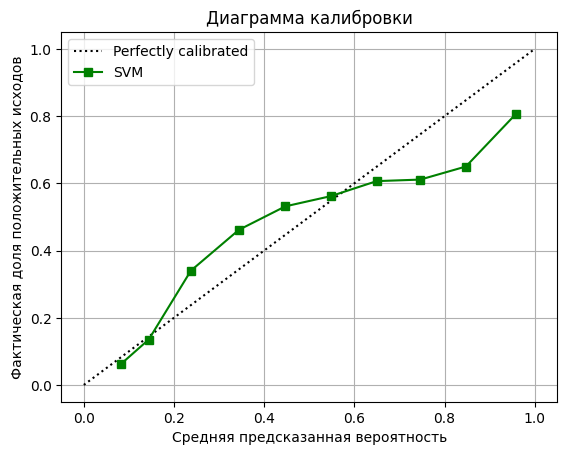

In [104]:
# Вычисляем калибровку для SVM
X_calib_preprocessed = preprocessor.transform(X_calib)

prob_true_svm, prob_pred_svm = calibration_curve(y_calib, final_model.predict_proba(X_calib_preprocessed)[:,1], n_bins=10)

# Строим диаграмму калибровки
plt.figure(figsize=(6,6))

CalibrationDisplay(prob_true_svm, prob_pred_svm, y_calib).plot(label='SVM', color='green')

plt.title("Диаграмма калибровки")
plt.xlabel("Средняя предсказанная вероятность")
plt.ylabel("Фактическая доля положительных исходов")
plt.legend()
plt.grid(True)
plt.show()

In [117]:
# Калибруем с помощью Platt Scaling (sigmoid)
calibrator_platt = CalibratedClassifierCV(final_model, method="sigmoid", cv=None)

calibrator_platt.fit(X_calib_preprocessed, y_calib) 


# Получаем вероятности на тестовой выборке
p_raw = final_model.predict_proba(X_test_preprocessed)[:, 1]         # исходные вероятности
p_calibrated = calibrator_platt.predict_proba(X_test_preprocessed)[:, 1]  # откалиброванные

На моем компьютере невозможно использовать FrozenEstimator - поэтому не использую, но подразумеваю, что его , конечно, стоит использовать!!!

Мы построили диаграмму калибровки нашей модели, затем откалибровали ее с помощью Platt Scaling (sigmoid).

###  Применение методов калибровки
Для калибровки используем `CalibratedClassifierCV` с методом `'isotonic'`.
Для процедуры подготовим отдельную калибровочную выборку. Посчитаем метрики калибровки:  
Оценка Бриера — средняя ошибка предсказанной вероятности.  
Дополнительная метрика ECE: среднее расхождение вероятностей.  
Дополнительная метрика MCE: максимальное расхождение вероятностей.  


In [118]:
# ---------------------------
def calculate_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0
    n = len(y_true)
    for i, (bin_lower, bin_upper) in enumerate(zip(bins[:-1], bins[1:])):
        if i == n_bins - 1:
            mask = (y_prob >= bin_lower) & (y_prob <= bin_upper)
        else:
            mask = (y_prob >= bin_lower) & (y_prob < bin_upper)

        # Проверяем, есть ли в текущем бине хотя бы один пример.
        if np.sum(mask) > 0:
            bin_size = np.sum(mask)

            # Вычисляем среднюю предсказанную уверенность (confidence) для бина.
            bin_conf = np.mean(y_prob[mask])

            # Вычисляем среднюю точность (долю правильных ответов) в этом бине.
            bin_acc = np.mean(y_true[mask])

            # Вычисляем вклад текущего бина в общую ошибку.
            # Это абсолютная разница, умноженная на количество примеров в бине.
            contribution = np.abs(bin_conf - bin_acc) * bin_size
            ece += contribution

    return ece / n


def calculate_mce(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    max_error = 0
    for i, (bin_lower, bin_upper) in enumerate(zip(bins[:-1], bins[1:])):
        if i == n_bins - 1:
            mask = (y_prob >= bin_lower) & (y_prob <= bin_upper)
        else:
            mask = (y_prob >= bin_lower) & (y_prob < bin_upper)

        # Продолжаем, только если в бине есть хотя бы один объект.
        if np.sum(mask) > 0:
            # Вычисляем среднюю уверенность модели для этого бина.
            # Вычисляем среднюю предсказанную уверенность (confidence) для бина.
            bin_conf = np.mean(y_prob[mask])

            # Вычисляем среднюю точность (долю правильных ответов) в этом бине.
            bin_acc = np.mean(y_true[mask])

            # Вычисляем абсолютную разницу между точностью и уверенностью.
            diff = np.abs(bin_conf - bin_acc)  # _______ Ваш код

            # Обновляем максимальную ошибку, если текущая разница больше.
            max_error = max(max_error, diff)

    # Возвращаем наибольшую найденную разницу.
    return max_error

Оценка Бриера до калибровки: 0.1303
Оценка Бриера после калибровки: 0.1300
ECE до калибровки: 0.2587, после калибровки: 0.2550
MCE до калибровки: 0.7529, после калибровки: 0.7411


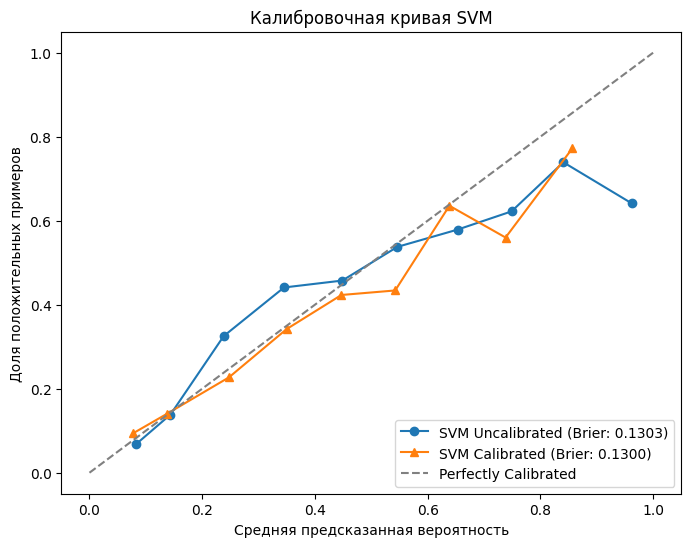

In [119]:

# Вычисляем сырые вероятности
proba_uncalibrated = final_model.predict_proba(X_test_preprocessed)[:, 1]

# Оцениваем качество модели ДО калибровки
brier_before = brier_score_loss(y_test, proba_uncalibrated)

#№frozen_svm = FrozenEstimator(final_model) # Доступно в scikit-learn >= 1.6.0

# Подготовка калиброванной модели с isotonic regression
calibrator_isotonic = CalibratedClassifierCV(
    estimator=final_model,     # Базовая модель (SVM)
    method='isotonic',        # Сигмоидная калибрация
    cv=None              # Генератор фолдов
)

calibrator_isotonic.fit(X_calib_preprocessed, y_calib)

# Прогнозируем вероятность на тестовом множестве ПОСЛЕ калибровки
proba_calibrated = calibrator_isotonic.predict_proba(X_test_preprocessed)[:, 1]

# Оцениваем качество модели ПОСЛЕ калибровки
brier_after = brier_score_loss(y_test, proba_calibrated)

# Печать оценок Бриера
print(f"Оценка Бриера до калибровки: {brier_before:.4f}")
print(f"Оценка Бриера после калибровки: {brier_after:.4f}")

# Статистики ECE и MCE

ece_before = calculate_ece(proba_uncalibrated, y_test)
ece_after = calculate_ece(proba_calibrated, y_test)
mce_before = calculate_mce(proba_uncalibrated, y_test)
mce_after = calculate_mce(proba_calibrated, y_test)

print(f"ECE до калибровки: {ece_before:.4f}, после калибровки: {ece_after:.4f}")
print(f"MCE до калибровки: {mce_before:.4f}, после калибровки: {mce_after:.4f}")

# Рисование калибровочной кривой
plt.figure(figsize=(8, 6))

# Кривая для необработанной модели
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, proba_uncalibrated, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f'SVM Uncalibrated (Brier: {brier_before:.4f})')

# Кривая для откалиброванной модели
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, proba_calibrated, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, marker='^', label=f'SVM Calibrated (Brier: {brier_after:.4f})')

# Идеальная линия
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля положительных примеров')
plt.title('Калибровочная кривая SVM')
plt.legend(loc='lower right')
plt.show()

### Сравнение по полученным метрикам модели до и после калибровки
Модель после калибровки показывает лучшие  метрики, это же видно и по калибровочной кривой.

## Финальный отчёт и выводы

### Единая таблица результаов

Сведем полученные результаты:

#### Характеристики базовой модели `DummyClassifier`.
Dummy
precision recall f1-score support
0 0.83 1.00 0.91 8279
1 0.00 0.00 0.00 1721
-accuracy 0.83 10000
-macro avg 0.41 0.50 0.45 10000
-weighted avg 0.69 0.83 0.75 10000

#### Характеристики финальной модели.
Характеристики финальной модели подбирались с учетом подбора гипервпараметров. Было выбрано 2 модели:  
Лучшая модель LogisticRegression:  
Параметры: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2'}  
Лучший score (AP): 0.4033  

Лучшая модель SVC:  
Параметры: {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}  
Лучший score (AP): 0.3780  

И лучшей моделью я посчитала модель SVC. Вот ее характеристики:
- final_model = SVC(C=10, gamma=0.01, kernel='rbf', probability=True)

#### Метрики до и после калибровки.
Метрики до и после калибровки:  
-Оценка Бриера до калибровки: 0.1303  
-Оценка Бриера после калибровки: 0.1300  
-ECE до калибровки: 0.2587, после калибровки: 0.2550  
-MCE до калибровки: 0.7529, после калибровки: 0.7411  
После калибровки метрики немного улучшились. 

#### Топ-5 самых важных признаков.
Самыми важными признаками для определения вероятности клика на баннер оказались: [ 'site_id', 'app_id',  'C18', 'ml_feature_2', 'ml_feature_7']

## Основные выводы 
Подбор гиперпараметров, отбор признаков и калибровка модели позволили улучшить качество модели по сравнению с базовой.  
По итогам работы с моделью мы увидели, что следующие признаки больше всего влияют на вероятность клика:  
Модель потребовала калибровки, после применения модели с isotonic regression оценки модели улучшились  
Финальная модель теперь готова к использованию в продакшене.  

### Рекомендации  
Хотя  модели машинного обучения показывают, что они могут подбирать признаки, важные для моделирования, сами, я бы все таки рекомендовала для этого проекта узнать физический смысл некоторых закодированных признаков для того, чтобы понимать, что в действительности они могут говорить о пользователе, сделавшем клик. 

Дополнительно можно попробовать обучить модель на всех признаках, чтобы она сама отобрала нужные и сравнить результаты.  

Также можно было порекомендовать попробовать расширить набор гиперпараметров для подбора в автоматическом режиме (ксожалению, сама сейчас этого сделат не смогла, не позволили вычислительные ресурсы компьютера.)  


## Сохранение модели для продакшена

### Сохраните артефакты

Сохраним:
1. пайплайн предобработки данных `preprocessor`;
2. финальную модель `calibrator_isotonic`;
3. информацию о выбранных признаках.


In [120]:
# Добавляйте версию и дату в имя файла
model_name = f"click_prediction_V1_11022026.joblib"

# Сохраняйте метаданные вместе с моделью
metadata = {
    'model_version': '1.0',
    'training_date': '2026-02-08',
    'accuracy': 0.89
}

joblib.dump({
    'preprocessor':preprocessor,
    'model': calibrator_isotonic,
    'properties': columns_list,
    'metadata': metadata
}, model_name)

['click_prediction_V1_11022026.joblib']

### Проверка работоспособность сохраненного кода

- Загрузим сохранённые артефакты.
- Сделаем предсказания на новых данных.
- Убедимся, что модель работает.

In [124]:
loaded_data = joblib.load(model_name)
loaded_model = loaded_data['model']
loaded_preprocessor = loaded_data['preprocessor']
columns_need = loaded_data['properties']

test_item = X_test
test_item_preprocessed = loaded_preprocessor.transform(X_test)
prediction = loaded_model.predict(test_item_preprocessed)
# Выведем 5-10 строк
n_to_show = min(10, len(prediction))
print(f"Показано {n_to_show} из {len(prediction)} предсказаний:\n")
print("-" * 40)

for i in range(n_to_show):
    if hasattr(prediction[i], 'round'):  # для числовых значений
        print(f"[{i:2d}] → {prediction[i]:.4f}")
    else:  # для категорий
        print(f"[{i:2d}] → {prediction[i]}")

print("-" * 40)
print(f"Форма предсказаний: {prediction.shape}")

Показано 10 из 10000 предсказаний:

----------------------------------------
[ 0] → 0.0000
[ 1] → 0.0000
[ 2] → 0.0000
[ 3] → 0.0000
[ 4] → 0.0000
[ 5] → 0.0000
[ 6] → 0.0000
[ 7] → 0.0000
[ 8] → 0.0000
[ 9] → 0.0000
----------------------------------------
Форма предсказаний: (10000,)


In [ ]:
Мы убедились, что сохранение и повторная загрузка модели работает.